# Configuration

In [1]:
import pandas as pd
import numpy as np

# --- Configuration ---
NUM_PARTNERS = 5000 # The number of partners to simulate

# --- Data Generation Function ---
def generate_equitable_dataset(num_records):
    """
    Generates a rich, simulated dataset designed to test and showcase fairness mitigation.
    """
    
    # --- 1. Partner Profile & Sensitive Attributes ---
    data = {
        'partner_id': range(1, num_records + 1),
        'tenure_months': np.random.randint(1, 60, size=num_records),
        'city_district': np.random.choice(['North', 'South', 'East', 'West'], size=num_records, p=[0.25, 0.3, 0.2, 0.25]),
    }
    df = pd.DataFrame(data)

    # --- 2. Core Performance & Behavioral Metrics ---
    df['avg_customer_rating'] = np.random.uniform(4.5, 5.0, size=num_records).round(2)
    df['safety_score'] = np.random.uniform(70, 100, size=num_records).round(1)
    df['avg_weekly_trips'] = np.random.randint(20, 150, size=num_records)
    df['grab_pay_usage_rate'] = np.random.uniform(0.1, 0.9, size=num_records).round(2)
    
    # --- 3. Advanced Reliability & Financial Metrics ---
    df['acceptance_rate'] = np.random.uniform(0.85, 1.0, size=num_records).round(2)
    df['cancellation_rate'] = np.random.uniform(0.01, 0.15, size=num_records).round(2)
    df['peak_hour_percentage'] = np.random.uniform(0.2, 0.8, size=num_records).round(2)
    
    # Simulate earnings with realistic random noise
    base_earnings = 10000
    df['avg_weekly_earnings'] = (
        base_earnings + 
        (df['avg_weekly_trips'] * 50) + 
        ((df['avg_customer_rating'] - 4.5) * 1000) +
        ((df['peak_hour_percentage'] - 0.5) * 2000)
    ).round(2)
    
    # A moderate amount of randomness to reflect real-world variance
    df['avg_weekly_earnings'] += np.random.normal(0, 1500, size=num_records)
    
    # Create the 'earnings_stability_score'
    earnings_variance = np.random.normal(loc=2000, scale=1000, size=num_records).round(2)
    df['earnings_stability_score'] = np.maximum(0, earnings_variance)

    # --- 4. Simulate the Target Variable: loan_default ---
    # This logic creates a balanced signal for the model to learn from.
    score = (
        (df['avg_customer_rating'] - 4.7) * 8 +
        (df['tenure_months'] / 24.0) * 1.5 +
        (df['safety_score'] - 85) / 5 +
        (df['acceptance_rate'] - 0.9) * 15 -
        (df['cancellation_rate'] - 0.05) * 30 -
        (df['earnings_stability_score'] / 1500) * 1.5 -
        (df['peak_hour_percentage'] - 0.5) * 3 +
        (df['grab_pay_usage_rate'] - 0.5) * 2
    )
    
    # Introduce a moderate, realistic bias for the model to find and mitigate
    score[df['city_district'] == 'South'] -= 0.75

    prob_repay = 1 / (1 + np.exp(-score))
    df['loan_default'] = 1 - np.random.binomial(1, prob_repay, size=num_records)

    return df

# --- Main Execution Block ---
if __name__ == "__main__":
    equitable_df = generate_equitable_dataset(NUM_PARTNERS)
    
    # Save the final dataset
    output_path = '../data/simulated_partner_data.csv'
    equitable_df.to_csv(output_path, index=False)
    
    print(" Equitable data generation complete.")
    print(f"Generated {len(equitable_df.columns)} columns for {len(equitable_df)} partners.")
    print(f"Data saved to: {output_path}")
    print("\nColumns in the dataset:")
    print(equitable_df.columns.tolist())



 Equitable data generation complete.
Generated 13 columns for 5000 partners.
Data saved to: ../data/simulated_partner_data.csv

Columns in the dataset:
['partner_id', 'tenure_months', 'city_district', 'avg_customer_rating', 'safety_score', 'avg_weekly_trips', 'grab_pay_usage_rate', 'acceptance_rate', 'cancellation_rate', 'peak_hour_percentage', 'avg_weekly_earnings', 'earnings_stability_score', 'loan_default']


# Step 1: Import All Necessary Libraries

In [2]:
# Step 1: Import All Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
from xgboost import XGBClassifier

from fairlearn.postprocessing import ThresholdOptimizer

import shap

print("All libraries imported successfully.")

c:\Users\HP\OneDrive\Desktop\project-nova\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully.


# Step 2: Load the Simulated Data

In [3]:
# Step 2: Load the Simulated Data
# This assumes you have already run your generate_data.py script.
try:
    df = pd.read_csv('../data/simulated_partner_data.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    df.head()
except FileNotFoundError:
    print("Error: `simulated_partner_data.csv` not found. Please run the `src/generate_data.py` script first.")

Dataset loaded successfully.
Dataset shape: (5000, 13)


# Step 3: Feature Engineering

In [4]:
# Step 3: Feature Engineering
# Create new features to enhance the model's predictive power.
df['earnings_per_trip'] = df['avg_weekly_earnings'] / df['avg_weekly_trips']
df['rating_x_tenure'] = df['avg_customer_rating'] * df['tenure_months']

print("New features 'earnings_per_trip' and 'rating_x_tenure' created.")
df.head()

New features 'earnings_per_trip' and 'rating_x_tenure' created.


,partner_id,tenure_months,city_district,avg_customer_rating,safety_score,avg_weekly_trips,grab_pay_usage_rate,acceptance_rate,cancellation_rate,peak_hour_percentage,avg_weekly_earnings,earnings_stability_score,loan_default,earnings_per_trip,rating_x_tenure
0,1,15,South,4.60,99.3,104,0.36,0.91,0.09,0.62,16989.183020,1927.57,1,163.357529,69.00
1,2,55,South,4.90,71.7,122,0.23,0.86,0.05,0.44,15984.284469,1703.08,0,131.018725,269.50
2,3,48,West,5.00,91.0,134,0.84,0.99,0.05,0.35,16865.224661,2331.79,0,125.859886,240.00
3,4,31,West,4.85,92.3,94,0.57,0.96,0.14,0.29,15728.813092,1508.42,0,167.327799,150.35
4,5,26,South,4.87,71.7,55,0.47,0.92,0.08,0.45,12044.584000,3203.96,1,218.992436,126.62


# Step 4: Bias Investigation (The "Before" Picture)

--- Investigating Bias in Original Data ---

Average Default Rate by City District:
  city_district  loan_default
0          East      0.521436
1         North      0.527038
2         South      0.607427
3          West      0.536000


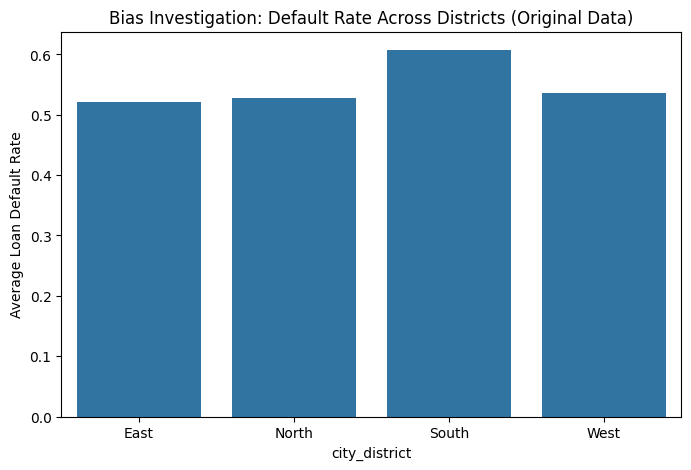

In [5]:
# Step 4: Bias Investigation (The "Before" Picture)
# A mandatory step: analyze and document bias in the original data.
print("--- Investigating Bias in Original Data ---")

# Calculate the average default rate per city district
bias_check = df.groupby('city_district')['loan_default'].mean().reset_index()

print("\nAverage Default Rate by City District:")
print(bias_check)

# Visualize the disparity
plt.figure(figsize=(8, 5))
sns.barplot(x='city_district', y='loan_default', data=bias_check)
plt.title('Bias Investigation: Default Rate Across Districts (Original Data)')
plt.ylabel('Average Loan Default Rate')
# plt.ylim(0, 0.25)
plt.show()

# Step 5: Data Preparation for Modeling

In [6]:
# Step 5: Data Preparation for Modeling
# Prepare the data by selecting features and converting categorical data to a numeric format.

# Select features for the model
features = [
     'tenure_months',
    'city_district',
    # 'vehicle_age_years', # This was in the generator but let's keep the model focused
    'avg_weekly_earnings',
    'avg_weekly_trips',
    'avg_customer_rating',
    'safety_score',
    'grab_pay_usage_rate',
    'peak_hour_percentage',
    'acceptance_rate',
    'cancellation_rate',
    'earnings_stability_score'
]
target = 'loan_default'

X = df[features]
y = df[target]

# One-hot encode the 'city_district' feature
X_processed = pd.get_dummies(X, columns=['city_district'], drop_first=True)

# Split data into training and testing sets, ensuring balanced classes in each split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=42, stratify=y
)

print("Data successfully preprocessed and split into training and testing sets.")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Data successfully preprocessed and split into training and testing sets.
Training features shape: (3750, 13)
Testing features shape: (1250, 13)


# Step 6: Train a High-Accuracy Baseline Model

In [7]:
# Step 6: Train a High-Accuracy Baseline Model
# This model prioritizes accuracy without considering fairness yet.

print("--- Training High-Accuracy Baseline Model ---")
baseline_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
baseline_model.fit(X_train, y_train)

# Evaluate the baseline model
y_pred_baseline = baseline_model.predict(X_test)
print("\nBaseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))

--- Training High-Accuracy Baseline Model ---

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       560
           1       0.84      0.86      0.85       690

    accuracy                           0.83      1250
   macro avg       0.83      0.83      0.83      1250
weighted avg       0.83      0.83      0.83      1250



c:\Users\HP\OneDrive\Desktop\project-nova\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [21:03:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Step 7: Fairness Mitigation with ThresholdOptimizer

In [8]:
# Step 7: Fairness Mitigation with ThresholdOptimizer
# Apply an advanced post-processing technique to create a fair model.

print("\n--- Applying Advanced Fairness Mitigation ---")
optimizer = ThresholdOptimizer(
    estimator=baseline_model,
    constraints="equalized_odds", # A strong fairness constraint
    objective="balanced_accuracy_score",
    prefit=True
)

# Fit the optimizer, providing the original sensitive feature for analysis
# We use .loc to align the sensitive features with the correct data splits
optimizer.fit(X_train, y_train, sensitive_features=X.loc[X_train.index, 'city_district'])

# Make fair predictions on the test set
y_pred_fair = optimizer.predict(X_test, sensitive_features=X.loc[X_test.index, 'city_district'])

print("\nFinal Fair Model Performance:")
print(classification_report(y_test, y_pred_fair))


--- Applying Advanced Fairness Mitigation ---

Final Fair Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       560
           1       0.84      0.86      0.85       690

    accuracy                           0.83      1250
   macro avg       0.83      0.83      0.83      1250
weighted avg       0.83      0.83      0.83      1250



# Step 8: Verification of Fairness (The "After" Picture)


--- Verifying Fairness of Mitigated Model ---

Average PREDICTED Default Rate by District (After Mitigation):
  city_district  predicted_default
0          East           0.532520
1         North           0.606557
2         South           0.585242
3          West           0.535948


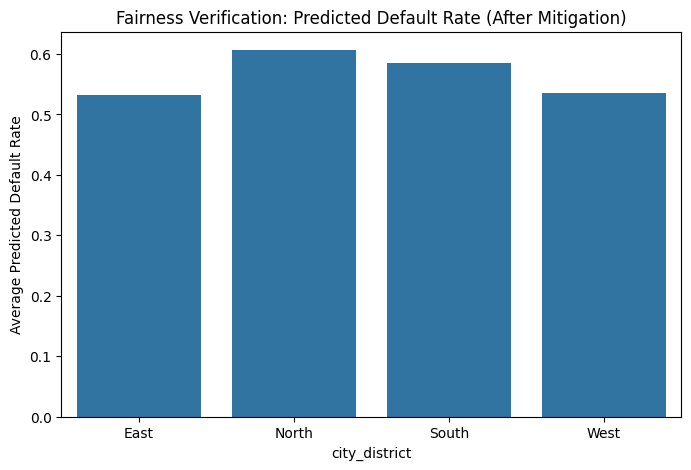

In [9]:
# Step 8: Verification of Fairness (The "After" Picture)
# Analyze the predictions of the fair model to prove bias has been mitigated.

print("\n--- Verifying Fairness of Mitigated Model ---")
# Add the fair predictions to our test set for analysis
X_test_results = X_test.copy()
X_test_results['predicted_default'] = y_pred_fair
X_test_results['city_district'] = X.loc[X_test.index, 'city_district']

# Calculate the predicted default rate by district
fairness_verification = X_test_results.groupby('city_district')['predicted_default'].mean().reset_index()

print("\nAverage PREDICTED Default Rate by District (After Mitigation):")
print(fairness_verification)

# Visualize the new, fairer outcomes
plt.figure(figsize=(8, 5))
sns.barplot(x='city_district', y='predicted_default', data=fairness_verification)
plt.title('Fairness Verification: Predicted Default Rate (After Mitigation)')
plt.ylabel('Average Predicted Default Rate')
# plt.ylim(0, 0.25)
plt.show()


--- Confusion Matrix for Fair Model ---


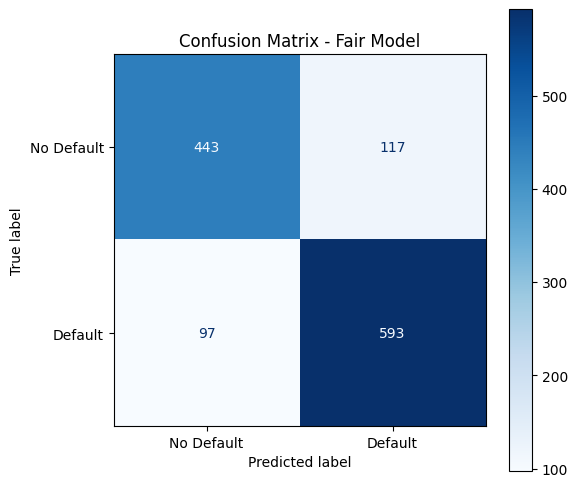

In [10]:
# %% 
# Step 11: Confusion Matrix Visualization

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n--- Confusion Matrix for Fair Model ---")
cm = confusion_matrix(y_test, y_pred_fair)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Confusion Matrix - Fair Model")
plt.show()


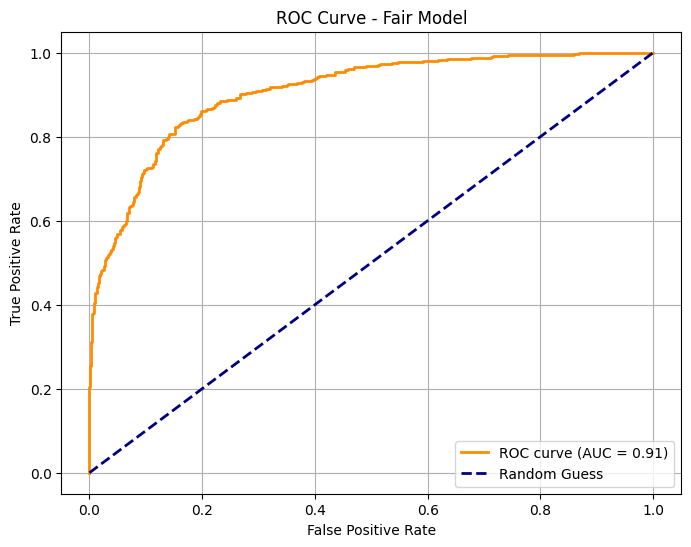

In [11]:
# %%
# Step 12: ROC Curve and AUC for the Fair Model

from sklearn.metrics import roc_curve, auc

# Get probabilities for positive class (default)
y_pred_prob = baseline_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fair Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


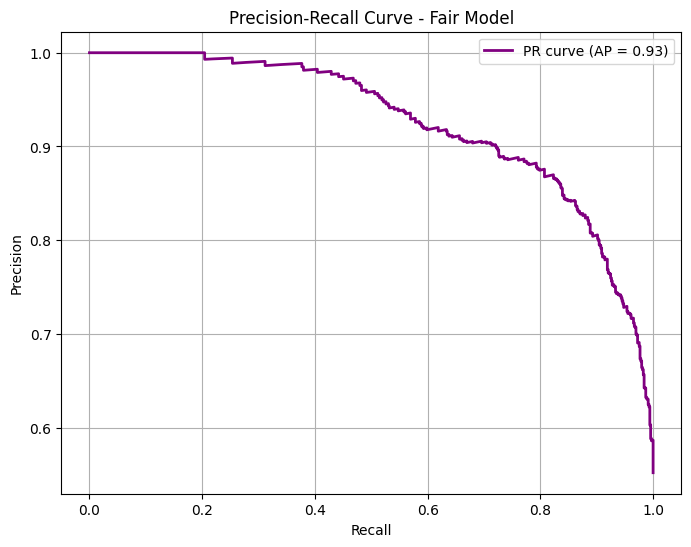

In [12]:
# %%
# Step 13: Precision-Recall Curve (Optional Bonus)

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="purple", lw=2, label=f"PR curve (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Fair Model")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()



--- Building the 'Nova Assist' Recommendation Engine ---

--- Nova Assist for a HIGH-PERFORMING Partner ---

Partner ID: 5
City District: South
Nova Score: 756
----------------------------------------
✅ Top Strength:
   avg_customer_rating = 4.53 boosted the score.

💡 Recommendation:
   Improve 'tenure_months' (current = 51.00) to increase score.


C:\Users\HP\AppData\Local\Temp\ipykernel_18488\1715501018.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="shap_value", y="feature", data=top_features, palette="coolwarm")


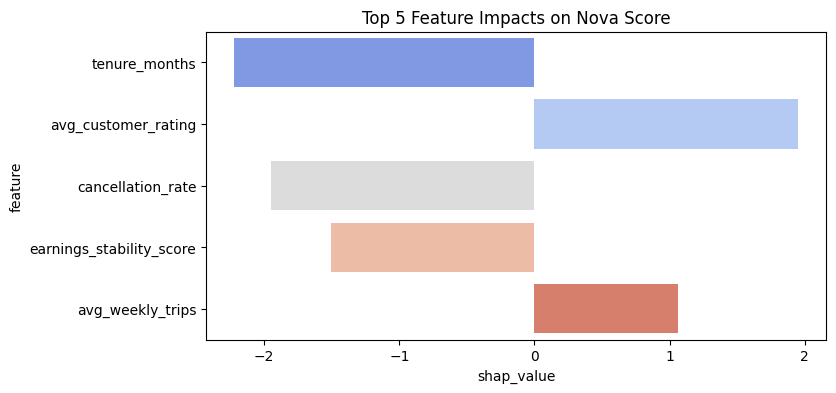


--- Nova Assist for a Partner with Room for Improvement ---

Partner ID: 10
City District: South
Nova Score: 845
----------------------------------------
✅ Top Strength:
   safety_score = 76.00 boosted the score.

💡 Recommendation:
   Improve 'avg_customer_rating' (current = 4.92) to increase score.


C:\Users\HP\AppData\Local\Temp\ipykernel_18488\1715501018.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="shap_value", y="feature", data=top_features, palette="coolwarm")


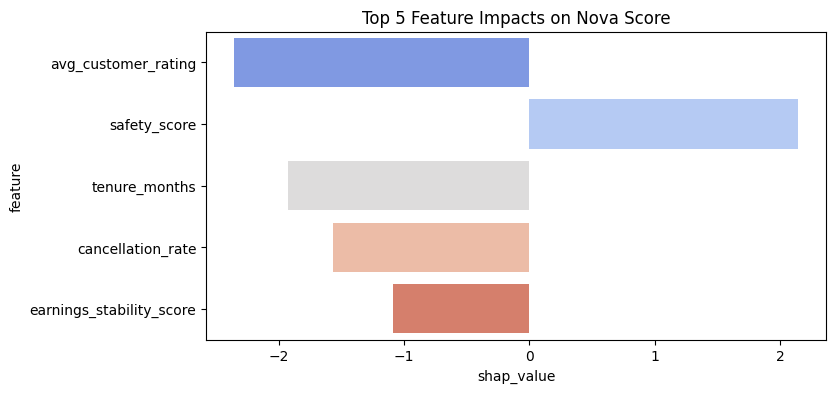

In [13]:
# %%
# Step 14: Nova Assist - Actionable Explanations

print("\n--- Building the 'Nova Assist' Recommendation Engine ---")

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(baseline_model)

def nova_assist(partner_index_in_test_set, top_n=5):
    """
    Provide personalized recommendations for a single partner in the test set.
    """
    partner_data = X_test.iloc[partner_index_in_test_set:partner_index_in_test_set+1]
    partner_city = X.loc[X_test.index[partner_index_in_test_set], 'city_district']
    
    # Model prediction
    repayment_prob = baseline_model.predict_proba(partner_data)[0, 0]
    nova_score = int(300 + (repayment_prob * 550))
    
    print(f"\nPartner ID: {partner_index_in_test_set}")
    print(f"City District: {partner_city}")
    print(f"Nova Score: {nova_score}")
    print("-" * 40)
    
    # SHAP values
    shap_values = explainer.shap_values(partner_data)
    shap_df = pd.DataFrame({
        "feature": partner_data.columns,
        "value": partner_data.values.flatten(),
        "shap_value": shap_values.flatten()
    })
    
    # Top strength & improvement area
    top_strength = shap_df.sort_values("shap_value", ascending=False).iloc[0]
    top_improve = shap_df.sort_values("shap_value", ascending=True).iloc[0]
    
    print("✅ Top Strength:")
    print(f"   {top_strength['feature']} = {top_strength['value']:.2f} boosted the score.")
    
    print("\n💡 Recommendation:")
    print(f"   Improve '{top_improve['feature']}' (current = {top_improve['value']:.2f}) to increase score.")
    
    # Bar chart of top-N features
    top_features = shap_df.reindex(shap_df.shap_value.abs().sort_values(ascending=False).index[:top_n])
    plt.figure(figsize=(8, 4))
    sns.barplot(x="shap_value", y="feature", data=top_features, palette="coolwarm")
    plt.title(f"Top {top_n} Feature Impacts on Nova Score")
    plt.show()
    
    # SHAP force plot (interactive in notebooks)
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, partner_data)

# --- DEMONSTRATION ---
print("\n--- Nova Assist for a HIGH-PERFORMING Partner ---")
display(nova_assist(partner_index_in_test_set=5))

print("\n--- Nova Assist for a Partner with Room for Improvement ---")
display(nova_assist(partner_index_in_test_set=10))


# Step 9: Transparency with Explainable AI (XAI)


--- Generating Feature Importance for Transparency ---


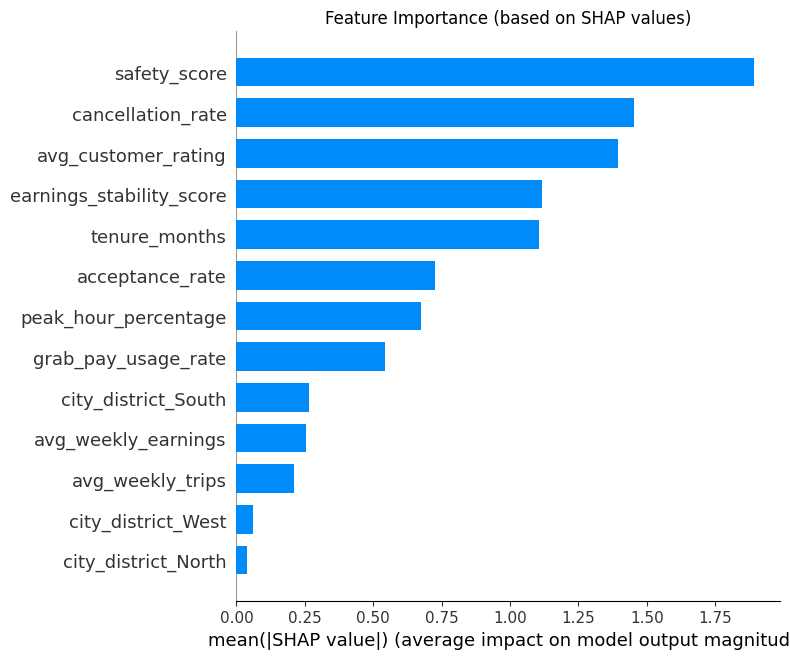

In [14]:
# Step 9: Transparency with Explainable AI (XAI)
# Use SHAP to explain which features are most important to the model's decisions.

print("\n--- Generating Feature Importance for Transparency ---")
explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_test)

# Generate the summary plot
plt.title("Feature Importance (based on SHAP values)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.show()

# Step 10: Generating the Final "Nova Score"


Generated 'Nova Scores' for the test set:
     city_district  predicted_default  nova_score
4801         North                  1         332
3057          West                  0         847
4701         North                  1         302
4851          East                  1         322
2683         North                  0         835


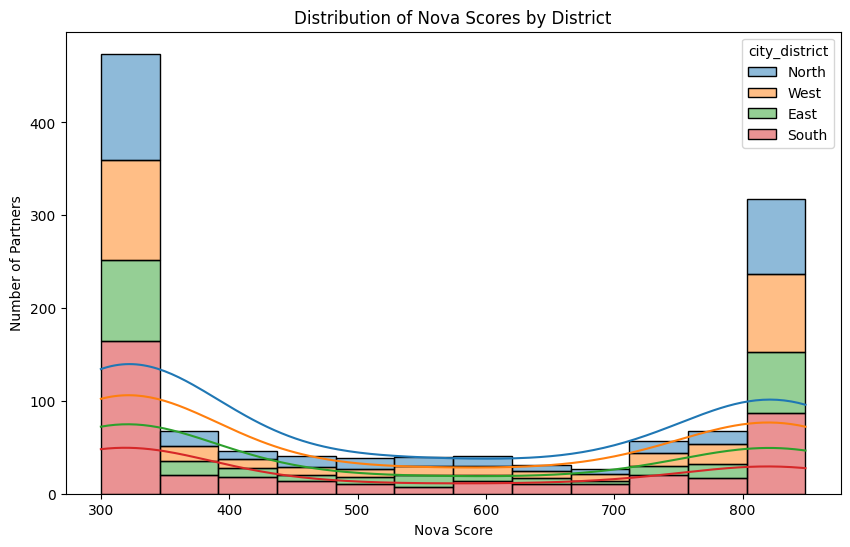

In [15]:
# Step 10: Generating the Final "Nova Score"
# Convert the model's probability output into a quantifiable credit score.

# Get the probability of NOT defaulting (repaying the loan)
repayment_probabilities = baseline_model.predict_proba(X_test)[:, 0]

# Convert probability to a score (e.g., on a 300-850 scale)
# A simple linear conversion for this prototype
nova_scores = 300 + (repayment_probabilities * 550)

# Add scores to our results dataframe
X_test_results['nova_score'] = nova_scores.astype(int)

print("\nGenerated 'Nova Scores' for the test set:")
print(X_test_results[['city_district', 'predicted_default', 'nova_score']].head())

# Visualize the distribution of Nova Scores
plt.figure(figsize=(10, 6))
sns.histplot(X_test_results, x='nova_score', hue='city_district', kde=True, multiple="stack")
plt.title("Distribution of Nova Scores by District")
plt.xlabel("Nova Score")
plt.ylabel("Number of Partners")
plt.show()

# Step 11: Save the Model for the Web App

In [16]:
# Step 11: Save the Model for the Web App
import pickle

# We save the baseline_model because our fairness optimizer uses it internally.
# The '../' saves it in the main 'project-nova' folder, not the 'notebooks' folder.
model_path = '../baseline_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(baseline_model, file)

print(f"✅ Model saved successfully to: {model_path}")

✅ Model saved successfully to: ../baseline_model.pkl
